In [1]:
import numpy as np
from stats import LinearSolveStats, TimeStepStats
from stats import TimeStepStats
from matplotlib import pyplot as plt
from plot_utils import *

data = load_data("../stats/fpm_2_open_solver_1.json")

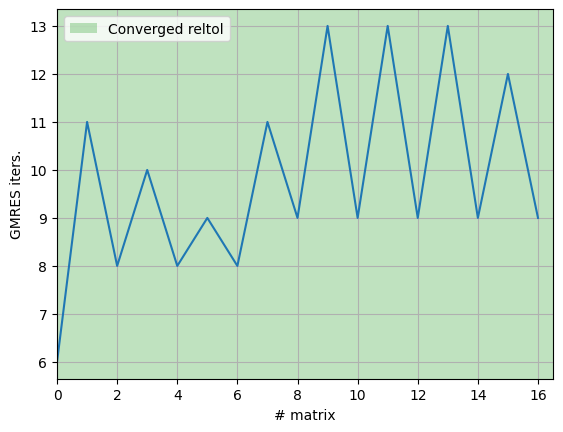

In [2]:
# %matplotlib ipympl
color_converged_reason(data)
plt.plot(get_gmres_iterations(data))
plt.ylabel('GMRES iters.')
plt.xlabel('# matrix')
# plt.yscale('log')
plt.legend()

In [3]:
mat_idx = 14
# mat_idx = 8
get_gmres_iterations(data)[mat_idx]

9

In [4]:
sticking, sliding, open = get_num_sticking_sliding_open(data)
print(sticking[mat_idx], sliding[mat_idx], open[mat_idx])

8 0 160


In [5]:
from plot_utils import *

mat, rhs = load_matrix_rhs(data, mat_idx)

In [6]:
import porepy as pp
import numpy as np
from mat_utils import *
from plot_utils import *
from fpm_2 import make_model
from pp_utils import make_row_col_dofs, make_reorder_contact

model = make_model()
model.prepare_simulation()

model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(model)

reorder = make_reorder_contact(model)
mat = mat[reorder]

# model.assemble_linear_system()
# mat, rhs = model.linear_system
model.linear_system = mat, rhs
perm_mat, prec_orig = model._prepare_solver()

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


Solve  took: 0.84


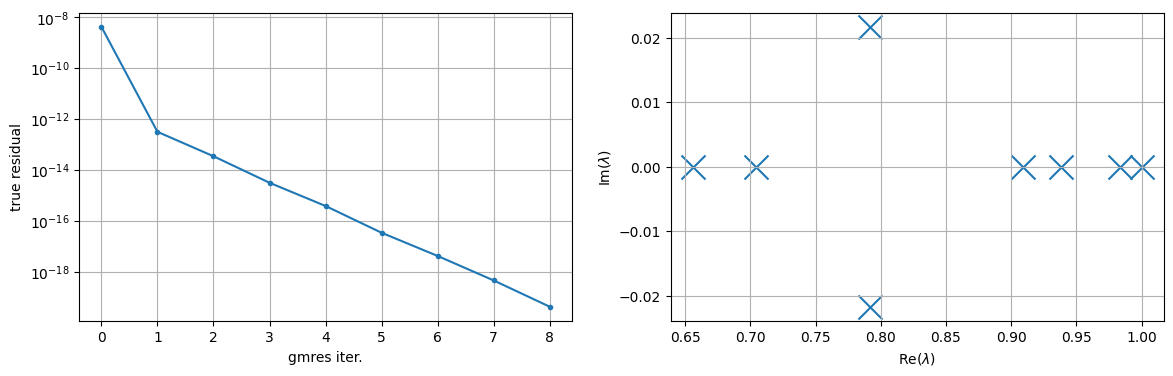

In [7]:
solve_petsc(perm_mat.mat, prec_orig, rhs=perm_mat.local_rhs(rhs))

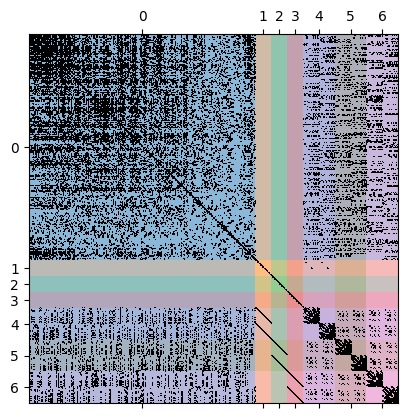

In [8]:
from block_matrix import BlockMatrixStorage
from pp_utils import correct_eq_groups

corrected_eq_dofs, corrected_eq_groups = correct_eq_groups(model)

J = BlockMatrixStorage(
    mat=mat,
    row_idx=corrected_eq_dofs,
    col_idx=model.var_dofs,
    groups_row=corrected_eq_groups,
    groups_col=model._variable_groups,
    group_row_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
    group_col_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$']
)

J[[1, 4, 5]].color_spy(False)

# J[:].color_spy()
# J[:].plot_max()
# J[:].matshow()

/home/porepy/simulations/plot_utils.py:102: RuntimeWarning: divide by zero encountered in log10
  mat = np.log10(abs(mat))


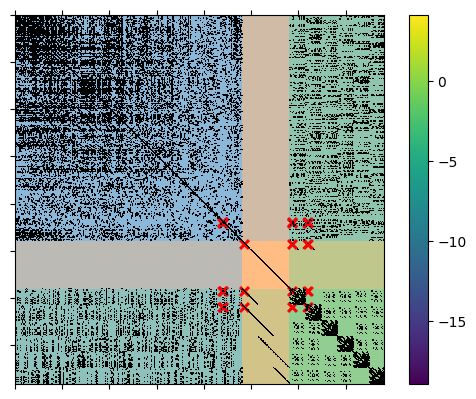

In [13]:
# %matplotlib tk
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization
from preconditioner_mech import build_mechanics_stabilization
from porepy.numerics.linalg.matrix_operations import sparse_kronecker_product

fractures = model.mdg.subdomains(dim=model.nd - 1)

tmp = J[[1, 4,5]]
J_51 = J[5, 1]
# tmp[[4, 5]] = build_mechanics_stabilization(model, J, build_schur=False)

tmp.color_spy(groups=True, show=False, aspect='equal', marker=',')
tmp.matshow(log=True, show=False)


for frac_idx, frac in enumerate(fractures):
    if frac_idx != 0:
        continue
    intfs = model.mdg.subdomain_to_interfaces(sd=frac)
    for intf in intfs:
        if intf.dim < frac.dim:
            continue

        matrix = model.mdg.interface_to_subdomain_pair(intf=intf)[0]
        assert matrix.dim == model.nd

        secondary_to_mortar = intf.secondary_to_mortar_avg(nd=model.nd).tocsc()
        mortar_to_primary = intf.mortar_to_primary_avg(nd=model.nd).tocsc()
        faces_to_cells = sparse_kronecker_product(
            matrix.cell_faces.T, nd=model.nd
        ).tocsc()
        secondary_to_mortar.eliminate_zeros()
        mortar_to_primary.eliminate_zeros()
        faces_to_cells.eliminate_zeros()

        frac_to_mat_cells = faces_to_cells @ mortar_to_primary @ secondary_to_mortar

        for frac_cell_id in range(frac.num_cells):
            if frac_cell_id != 8:
            # if frac_cell_id % 10 != 0:
                continue

            frac_cells = frac_cell_id * model.nd + np.arange(model.nd)
            intf_cells = secondary_to_mortar[:, frac_cells].indices
            mat_cells = frac_to_mat_cells[:, frac_cells].indices

            row_idx, col_idx = tmp.get_global_indices([intf_cells, intf_cells], group=(5, 5), subgroup=(frac_idx, frac_idx))
            for x in col_idx:
                for y in row_idx:
                    plt.scatter(x, y, color='r', marker='x', alpha=0.9)

            row_idx, col_idx = tmp.get_global_indices([frac_cells, intf_cells], group=(4, 5), subgroup=(frac_idx, frac_idx))
            for x in col_idx:
                for y in row_idx:
                    plt.scatter(x, y, color='r', marker='x', alpha=0.9)

            row_idx, col_idx = tmp.get_global_indices([frac_cells, frac_cells], group=(4, 4), subgroup=(frac_idx, frac_idx))
            for x in col_idx:
                for y in row_idx:
                    plt.scatter(x, y, color='r', marker='x', alpha=0.9)

            row_idx, col_idx = tmp.get_global_indices([intf_cells, frac_cells], group=(5, 4), subgroup=(frac_idx, frac_idx))
            for x in col_idx:
                for y in row_idx:
                    plt.scatter(x, y, color='r', marker='x', alpha=0.9)

            row_idx, col_idx = tmp.get_global_indices([intf_cells, mat_cells], group=(5, 1), subgroup=(frac_idx, 0))
            for x in col_idx:
                for y in row_idx:
                    plt.scatter(x, y, color='r', marker='x', alpha=0.9)

            row_idx, col_idx = tmp.get_global_indices([mat_cells, intf_cells], group=(1, 5), subgroup=(0, frac_idx))
            for x in col_idx:
                for y in row_idx:
                    plt.scatter(x, y, color='r', marker='x', alpha=0.9)

            row_idx, col_idx = tmp.get_global_indices([mat_cells, mat_cells], group=(1, 1), subgroup=(0, 0))
            for x in col_idx:
                for y in row_idx:
                    plt.scatter(x, y, color='r', marker='x', alpha=0.9)

            row_idx, col_idx = J_51.get_global_indices([intf_cells, mat_cells], group=(5, 1), subgroup=(frac_idx, 0))
            x = J_51.mat[row_idx]
            assert x[:, col_idx].nnz == 18

plt.show()

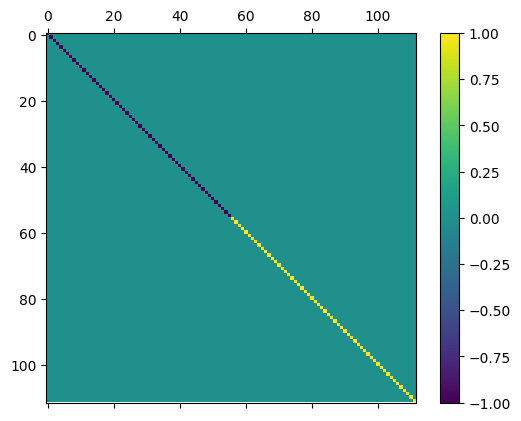

In [21]:
intf = model.mdg.subdomain_to_interfaces(sd=fractures[0])[0]
plot_mat(intf.sign_of_mortar_sides(), log=False)

In [24]:
intf.sign_of_mortar_sides().data

array([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]])